In [3]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

df = pd.read_parquet("../data/processed/model_ready.parquet")
aapl = df[df['ticker'] == 'AAPL'][['close']].copy()  
scaler = MinMaxScaler()
aapl_scaled = scaler.fit_transform(aapl)

def create_sequences(data, window_size=30):
    X, y = [], []
    for i in range(len(data)-window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

X, y = create_sequences(aapl_scaled)
print(f"X shape: {X.shape}, y shape: {y.shape}")  

X shape: (307, 30, 1), y shape: (307, 1)


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout , Input

model = Sequential([
    Input(shape=(30, 1)),  # Explicit Input layer
    LSTM(50, return_sequences=True),  # Removed input_shape parameter
    Dropout(0.2),
    LSTM(50),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.summary()  # Verify architecture

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 30, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.3090 - val_loss: 0.0695
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0347 - val_loss: 0.0159
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0158 - val_loss: 0.0157
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0074 - val_loss: 0.0168
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0086 - val_loss: 0.0107
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0061 - val_loss: 0.0106
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0056 - val_loss: 0.0113
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0053 - val_loss: 0.0104
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0060 - val_loss: 0.0105
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0052 - val_loss: 0.0102
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0052 - val_loss: 0.0103
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0049 - val_loss: 0.0102
E

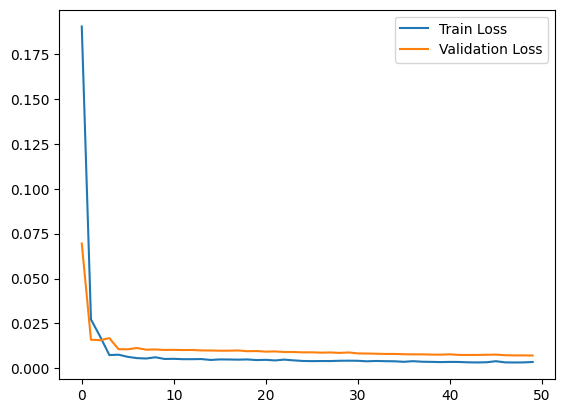

In [5]:
import matplotlib.pyplot as plt
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step

LSTM Performance:
- MAE: $6.14
- RMSE: $7.63


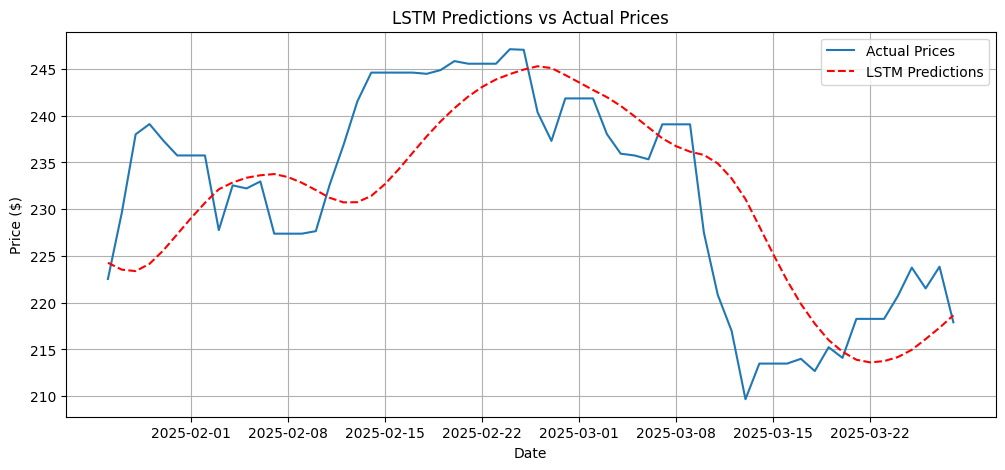

In [6]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)  

# 2. Reshape the arrays
y_test = y_test.reshape(-1, 1)  
y_pred = y_pred.reshape(-1, 1)   

y_test_actual = scaler.inverse_transform(y_test)
y_pred_actual = scaler.inverse_transform(y_pred)

mae = mean_absolute_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))

print(f"\nLSTM Performance:")
print(f"- MAE: ${mae:.2f}")
print(f"- RMSE: ${rmse:.2f}")

plt.figure(figsize=(12, 5))
plt.plot(aapl.index[-len(y_test_actual):], y_test_actual, label='Actual Prices')
plt.plot(aapl.index[-len(y_pred_actual):], y_pred_actual, 
         label='LSTM Predictions', color='red', linestyle='--')
plt.title("LSTM Predictions vs Actual Prices")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.show()

In [7]:
import joblib
from tensorflow import keras  
model.save("../src/models/lstm_aapl.keras")  
joblib.dump(scaler, "../src/models/lstm_scaler.pkl")
print("LSTM model (.keras) and scaler saved!")

LSTM model (.keras) and scaler saved!
